In [1]:
import torch
import torchaudio
from supervoice_valle import SupervoceNARModel, SupervoceARModel, Tokenizer, Supervoice
from train.dataset import load_sampler
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from vocos import Vocos
from encodec import EncodecModel
from encodec.utils import convert_audio

In [2]:
device = "cuda"
vocos = Vocos.from_pretrained("charactr/vocos-encodec-24khz").to(device)
tokenizer = Tokenizer("./tokenizer_text.model")
sampler = load_sampler("./external_datasets/libriheavy/libriheavy_cuts_small.jsonl.gz", "./external_datasets/libriheavy-encodec/", 1)

# Encodec model
encodec_model = EncodecModel.encodec_model_24khz()
encodec_model.set_target_bandwidth(6.0)
encodec_model.to(device)

# Load NAR
nar_model = SupervoceNARModel()
checkpoint = torch.load("./output/valle-35.pt", map_location = "cpu")
nar_model.load_state_dict(checkpoint['model'])
nar_model = nar_model.to(device)
nar_model.eval()
step = checkpoint['step']
print(checkpoint['step'])

# Load AR
ar_model = SupervoceARModel()
checkpoint = torch.load("./output/valle-ar-2.pt", map_location = "cpu")
ar_model.load_state_dict(checkpoint['model'])
ar_model = ar_model.to(device)
ar_model.eval()
step = checkpoint['step']
print(checkpoint['step'])

# Frontend
model = Supervoice(ar_model, nar_model, encodec_model, vocos, tokenizer)
model = model.to(device)

/home/steve/miniconda3/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


600000
600000


In [3]:
# def inference_nar(text, audio, coarse_tokens):
#     condition_text = tokenizer.encode(text).to(device)
#     condition_audio = audio.to(device)
#     predicted = [coarse_tokens.to(device)]
#     for i in range(1, 8):
#         p = nar_model(
#             condition_text = [condition_text], 
#             condition_audio = [condition_audio],
#             audio = [torch.stack(predicted)],
#             codec = [i]
#         )

#         p = p[0]
#         p = torch.nn.functional.softmax(p, dim=-1)
#         p = torch.argmax(p, dim=-1, keepdim=True)
#         p = p.squeeze(-1)
#         predicted.append(p)
#     predicted = torch.stack(predicted)
#     predicted = torch.cat([condition_audio, predicted], dim = 1)
#     return predicted

# def sample_ar(logits, top_k = 0, top_p = 0.1, prev = None):

#     # Top-k
#     if top_k > 0:

#         # Find all indices which value is less than k-th one
#         indices_to_remove = logits < torch.topk(logits, top_k, dim=-1)[0][..., -1, None]

#         # Assign minus infinity for such values
#         logits[indices_to_remove] = float('-inf')

#     # Top-p
#     if top_p > 0:

#         # Sort logits
#         sorted_logits, sorted_indices = torch.sort(logits, dim=-1, descending=True)

#         # Calculate cummulative probabilities
#         cum_sum_probs = torch.cumsum(torch.nn.functional.softmax(sorted_logits, dim=-1), dim=-1)

#         # Remove all indices with cummulative probability more than top_p
#         sorted_indices_to_remove = cum_sum_probs < top_p

#         # Shift the indices to the right to keep also the first token above the threshold
#         sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
#         sorted_indices_to_remove[..., 0] = 0

#         # Assign minus infinity for such values
#         sorted_logits[sorted_indices_to_remove] = float('-inf')
        
#         # Then reverse the sorting process by mapping back sorted_logits to their original position
#         logits = torch.gather(sorted_logits, 0, sorted_indices.argsort(-1))

#     # Argmax
#     # return torch.argmax(probs, dim=-1, keepdim=True).item()

#     # Softmax
#     probs = torch.nn.functional.softmax(logits, dim=-1)

#     # Sample
#     return torch.multinomial(probs, num_samples=1).item(), None

# def inference_ar(text, audio):
#     condition_text = tokenizer.encode(text).to(device)
#     audio_tokens = audio.to(device)
#     prev = None
#     while True:

#         # Inference
#         p = ar_model(
#             text = [condition_text],
#             audio = [audio_tokens]
#         )
#         p = p[0][-1]

#         # Sample code
#         code, prev = sample_ar(p, prev = prev)

#         # Append code
#         if (code > 1023) or audio_tokens.shape[0] > 2000:
#             break
#         audio_tokens = torch.cat([audio_tokens, torch.tensor([code], device = audio_tokens.device)])
#     return audio_tokens

def decode(tokens):
    features = vocos.codes_to_features(tokens.to("cuda"))
    bandwidth_id = torch.tensor([2]).to("cuda")  # 6 kbps
    return vocos.decode(features, bandwidth_id=bandwidth_id)  

# def load_audio(path):
#     wav, sr = torchaudio.load(path)
#     if sr != 16000:
#         wav = torchaudio.transforms.Resample(sr, 16000, dtype=wav.dtype)(wav)
#     wav = convert_audio(wav, 16000, encodec_model.sample_rate, encodec_model.channels)
#     wav = wav.unsqueeze(0)
#     with torch.no_grad():
#         encoded_frames = encodec_model.encode(wav.to(device))
#     codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1).squeeze().cpu()
#     return codes

In [4]:
# audio, text = sampler()
# text = text[0]
# audio = audio[0]
# print(text)
# display(Audio(data=decode(audio).cpu(), rate=24000))

In [5]:
# # NAR prediction
# predicted = inference_nar(text, audio[:,:75*3], audio[0,75*3:])
# display(Audio(data=decode(predicted).cpu(), rate=24000))

In [6]:
# # AR + NAR prediction
# predicted_ar = inference_ar(text, audio[0,:75*3])
# predicted = inference_nar(text, audio[:,:75*3], predicted_ar[75*3:])
# display(Audio(data=decode(predicted).cpu(), rate=24000))

In [7]:
# condition_audio = load_audio("./eval/9.wav")
# condition_text = "Gogs are sitting by the door!"
# condition_audio = load_audio("./eval/mkbhd.m4a")
# condition_text = "I really shouldn't be surprised by this at this point, but."
# condition_audio = load_audio("./eval/ltt.m4a")
# condition_text = "Here it is my friend a concrete proof in side tier trully is dead."
# voice = model.create_voice("./eval/10.wav", "Dogs are sitting by the door!")
# voice = model.create_voice("./eval/ltt.m4a", "Here it is my friend a concrete proof in side tier trully is dead.")
# voice = model.create_voice("./eval/elevenlabs.mp3", "God has given you one face and you make yourself another.")
# voice = model.create_voice("./eval/elevenlabs_2.mp3", "Government of the people, by the people, for the people shall not perish from the earth.")
voice = model.create_voice("./eval/hifitts_0.flac", "Even at the distance of the three miles.")
# voice = model.create_voice("./voices/voice_1.wav", "We had not stopped to study the Indian character.")
display(Audio(data=decode(voice["audio_tokens"]).cpu(), rate=24000))

In [22]:
predicted = model.synthesize("emo_1", "Dogs are sitting by the door!", top_p = 0.2)
display(Audio(data=predicted.cpu(), rate=24000))

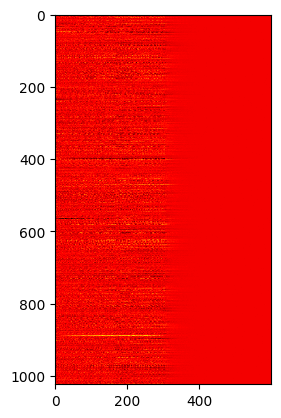

In [9]:
plt.imshow(ar_model.positional_embedding_text.weight.T[:,:600].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

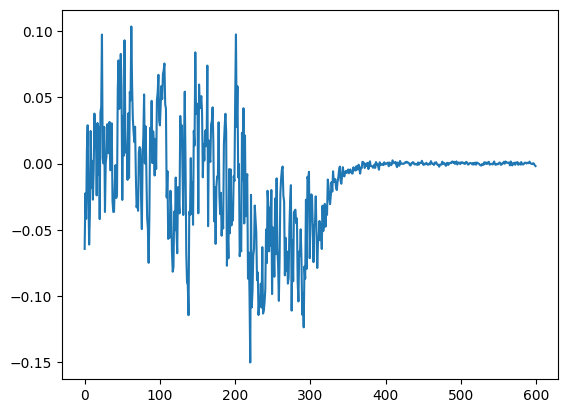

In [10]:
plt.plot(ar_model.positional_embedding_text.weight.T[56,:600].cpu().detach().numpy())
plt.show()

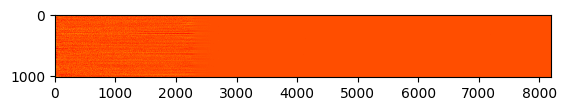

In [11]:
plt.imshow(ar_model.positional_embedding_audio.weight.T.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

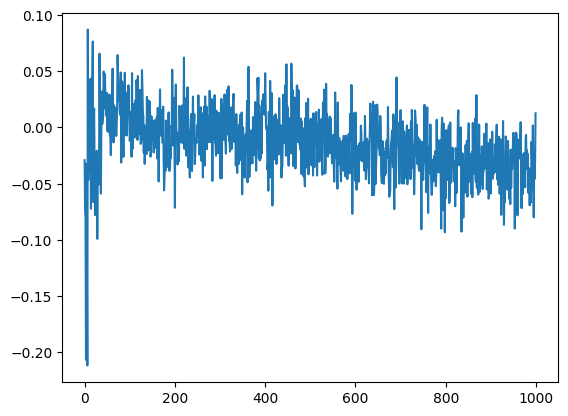

In [12]:
plt.plot(ar_model.positional_embedding_audio.weight.T[16, 0:1000].cpu().detach().numpy())
plt.show()